In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset, random_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import cv2
import torchvision
from torchvision import transforms as T
from torchvision import datasets, models
from torchvision.datasets import ImageFolder

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import wandb

# custom functions from my repo
%cd plant-pathology
from custom_functions.functions import get_images_shape, preprocess_csv
%cd ..

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
wandb.login()

In [ ]:
# set seed for reproducibility
LUCKY_SEED = 42
torch.manual_seed(LUCKY_SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(LUCKY_SEED)
np.random.seed(LUCKY_SEED)

## EDA
### First let's take a look at the width/height distribution of the images. This will come in handy for specifying custom datasets later

In [2]:
dir_path = '/images_folder'

height, width = get_images_shape(dir_path)

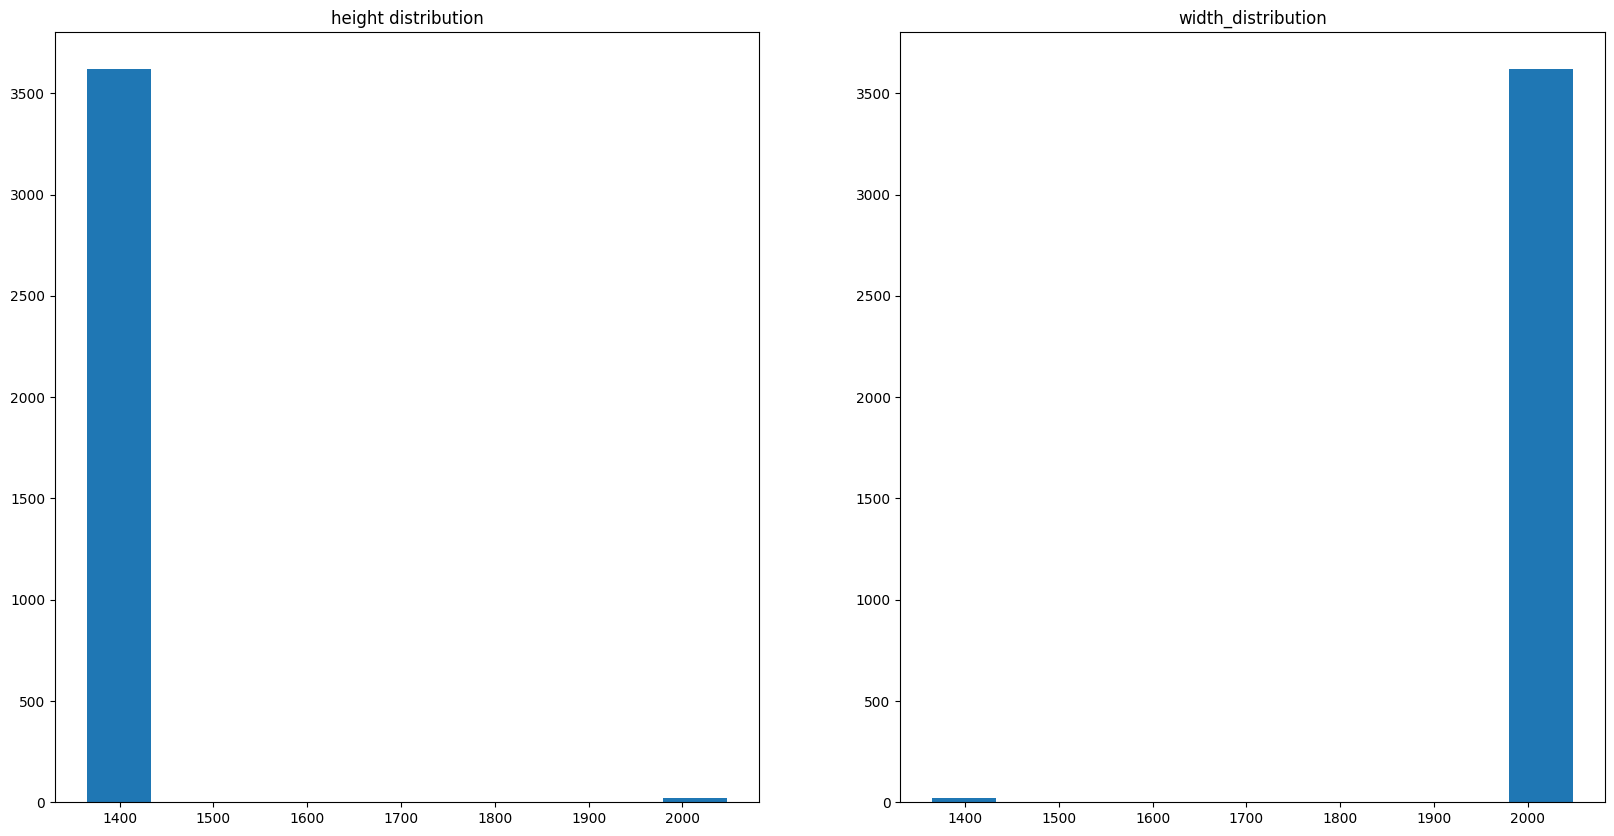

In [21]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.hist(height)
ax1.set_title("height distribution")

ax2.hist(width)
ax2.set_title("width_distribution")

figure.show()

### All images are about 1400x2000. This is quite a lot, so resize will be required

### Now let's look at train.csv, which contains labels of all images

In [4]:
train = pd.read_csv("train.csv")

In [16]:
train

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


### There is a separate column for each class, which is not very convenient. Let's convert the data to a single column format, where each class corresponds to a different number (1,2, ... etc.)

In [5]:
train = preprocess_csv(train)

train

,image_id,label
0,Train_0,3
1,Train_1,1
2,Train_2,0
3,Train_3,2
4,Train_4,0
...,...,...
1816,Train_1816,3
1817,Train_1817,0
1818,Train_1818,0
1819,Train_1819,2


### Let's look at class distribution

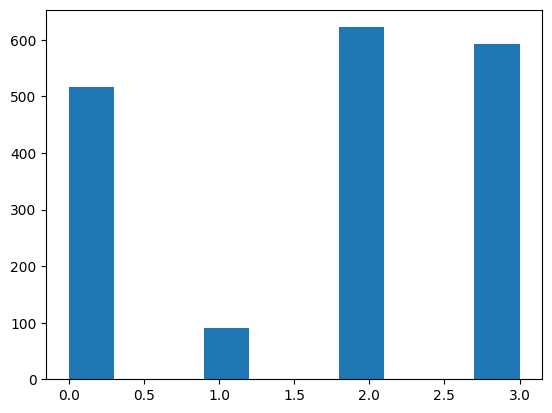

In [19]:
plt.hist(train["label"])
plt.show()

### Data is not balanced in relation to class 1 ("healthy"), so stratify split will be needed 

## Custom dataset specification

In [6]:
train, val = train_test_split(train, test_size = 0.2, random_state = 42, shuffle = True, stratify = train["label"])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, path, csv, transform = None):
        self.path = path
        self.csv = csv
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.path, self.csv.iloc[index, 0]) + ".jpg"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label = self.csv.iloc[index, 1]
        label = torch.tensor(label)
        
        if self.transform:
            aug = self.transform(image = img)
            img = aug["image"]
            
        return img, label

In [9]:
my_transform_train = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p = 0.25), # some simple augmentation never hurts
    A.VerticalFlip(p = 0.25),
    A.RandomBrightnessContrast(p = 0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet
    ToTensorV2()
])

my_transform_val = A.Compose([
    A.Resize(300, 300),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [11]:
train_dataset = CustomDataset(dir_path, train, transform = my_transform_train)
val_dataset = CustomDataset(dir_path, val, transform = my_transform_val)

trainloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valloader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

## Model specification

### We will fine-tune efficientnet_b3 by changing the head and freezing the remaining layers

In [22]:
model = models.efficientnet_b3(pretrained = True)

In [23]:
for param in model.parameters(): # freeze all params
    param.requires_grad = False

In [24]:
# custom head with 2 linear layers and dropout
class classifier_head(nn.Module):
    def __init__(self):
        super(classifier_head, self).__init__()
        self.fc1 = nn.Linear(1536, 128)
        self.fc2 = nn.Linear(128, 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.15)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [25]:
model.classifier = classifier_head()

## Train

In [ ]:
# define train func
model.to(device) # model was trained on GPU

wandb.init(project="plant_pathology", name="training_run") # track training  
wandb.watch(model)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
criterion = CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
num_epoch = 119

best_model_wts = model.state_dict()
best_f1 = 0.0

for epoch in range(num_epoch):
    running_loss_train = 0
    processed_data_train = 0
    running_loss_val = 0
    processed_data_val = 0
    predicted = []
    true = []
    model.train()
    for data, target in tqdm(trainloader, total = len(trainloader)):
        data = data.float().to(device)
        target = target.to(device)
        optimizer.zero_grad()
        probs = model(data)
        loss = criterion(probs, target)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * data.size(0)
        processed_data_train += data.size(0)
    train_loss = running_loss_train / processed_data_train
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(valloader, total = len(valloader)):
            data = data.float().to(device)
            target = target.to(device)
            probs = model(data)
            loss = criterion(probs, target)
            running_loss_val += loss.item() * data.size(0)
            processed_data_val += data.size(0)
            predicted.append(np.argmax(probs.cpu(), axis = 1))
            true.append(target.cpu().numpy())
        val_loss = running_loss_val / processed_data_val
        val_accuracy = accuracy_score(np.concatenate(true), np.concatenate(predicted))
        val_f1 = f1_score(np.concatenate(true), np.concatenate(predicted), average='macro')
        
        if val_f1 > best_f1:
                best_f1 = val_f1
                best_model_wts = model.state_dict()
        
    wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'accuracy': val_accuracy,
            'f1_score': val_f1
        })
    # not necessary as we are tracking via wandb
    #print("Epoch" + " " + str(epoch) + ":", "train_loss:" + str(train_loss), "val_loss:" + str(val_loss), "val_f1:" + str(val_f1), "val_acc:" + str(val_accuracy))
    scheduler.step()
wandb.finish()

In [29]:
wandb.finish()

accuracy,▁▆▄▆▅▆▅▄▇▇▇█▇█▇█▇▇█▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇▇█▇█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▅▅▅▆▆▆▇█▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▃▂▁▃▃▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁▂▁▂▁▁▁▂▁▁▁
accuracy,0.85205
epoch,119
f1_score,0.74808
train_loss,0.14075
val_loss,0.44824


### We got 0.748 f1 macro score and 0.852 accuracy on validation which is a pretty good result for unbalanced data

In [33]:
# save model for eval
torch.save(best_model_wts, "./weights")